In [1]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader,random_split, Dataset
from utils.fixes import global_seed
global_seed(42)
%matplotlib inline

Global seed set to 42


In [3]:
import selfies as sf

In [4]:
# chech GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
device = torch.device(device)
device

device(type='cuda')

In [251]:
smifile = "GDB17.50000000LLnoSR.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles"])
data = data.sample(n=2000000).reset_index(drop=True)

In [252]:
data.head()

,smiles
0,CC(C)N(C)C1COC2OC1(C)C1CCNC21
1,CCC(C)C1(CC(C)OC1(OC)C(O)=O)C#N
2,CC1(O)C2=C3N(C=NC3=CO2)C1(C)CCC#C
3,CC1CC2C(C#N)C(CCO)(C1)C(O)C2(C)C
4,CC(C)C1=C(CO)NC=CC=C2N=NOC2=N1


In [253]:
len(data)

2000000

In [258]:
def sanitize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        # return canonical smiles
        return Chem.MolToSmiles(mol)

In [259]:
data['smiles'] = data.smiles.apply(sanitize_smiles)

In [260]:
data['selfies'] = data.smiles.apply(sf.encoder)

In [261]:
data.head()

,smiles,selfies
0,CC(C)N(C)C1COC2OC1(C)C1CCNC21,[C][C][Branch1][C][C][N][Branch1][C][C][C][C][...
1,CCC(C)C1(C#N)CC(C)OC1(OC)C(=O)O,[C][C][C][Branch1][C][C][C][Branch1][Ring1][C]...
2,C#CCCC1(C)n2cnc3coc(c32)C1(C)O,[C][#C][C][C][C][Branch1][C][C][N][C][=N][C][=...
3,CC1CC2C(C#N)C(CCO)(C1)C(O)C2(C)C,[C][C][C][C][C][Branch1][Ring1][C][#N][C][Bran...
4,CC(C)c1nc2onnc2ccc[nH]c1CO,[C][C][Branch1][C][C][C][N][=C][O][N][=N][C][R...


In [262]:
#sort charset
alphabet = sf.get_alphabet_from_selfies(data.selfies)
alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet.add("[start]")
alphabet.add("[end]")
alphabet = list(sorted(alphabet))
pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 5  # 5
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}

In [263]:
print(f'Charset: {alphabet}')
print(f'Embedding length: {pad_to_len}')
print(f'Number of characters: {len(alphabet)}')

Charset: ['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[#Ring1]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[I]', '[N+1]', '[NH1]', '[N]', '[O-1]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S]', '[end]', '[nop]', '[start]']
Embedding length: 42
Number of characters: 31


In [264]:
import re
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len):
        self.alphabet = alphabet
        self.pad_to_len = pad_to_len
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
    def vectorize(self, selfie):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        X = np.zeros((self.pad_to_len, len(self.alphabet)))
        splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        for i, char in enumerate(splited):
            X[i, self.char2idx[char]] = 1
        return X
    def devectorize(self, ohe):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(self.pad_to_len):
            char = self.idx2char[np.argmax(ohe[j])]
            if char == '[start]':
                continue
            elif char == '[end]':
                break
            else:
                selfie_str += char
        return selfie_str

    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)

In [265]:
test = SELFIESVectorizer(alphabet, pad_to_len)
test_selfie = sf.encoder("CNCBr")

In [266]:
test_selfie

'[C][N][C][Br]'

In [267]:
test.split_selfi(test_selfie[0])

[]

In [268]:
vec = test.vectorize(test_selfie)
vec.shape

(42, 31)

In [269]:
decoded = test.devectorize(vec)
decoded

'[C][N][C][Br]'

In [270]:
X_train = data.selfies[3]
X_train = test.vectorize(X_train)
X_train.shape

(42, 31)

In [271]:
test.devectorize(X_train) == data.selfies[3]

True

In [272]:
class SELFIESDataset(Dataset):
    def __init__(self, data, vectorizer, alphabet, pad_to_len):
        self.data = data
        self.vectorizer = vectorizer(alphabet, pad_to_len)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.from_numpy(self.vectorizer.vectorize(self.data.selfies[idx])).float()

In [273]:
# Instantiate the dataset and dataloader objects
batch_size = 64
dataset = SELFIESDataset(data, SELFIESVectorizer, alphabet, pad_to_len)
train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))])

In [274]:
input_size = len(alphabet)
hidden_size = input_size
num_layers = 2

In [275]:
# rewrite the model to use Encoder and Decoder classes
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, latent_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.linear_size = pad_to_len * hidden_size
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.linear_size, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, latent_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        encoded, _ = self.encoder(x)
        encoded = self.flatten(encoded)
        encoded = self.dropout(self.relu(self.fc1(encoded)))
        encoded = self.fc2(encoded)
        return encoded
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, latent_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.linear_size = pad_to_len * hidden_size
        self.fc1 = nn.Linear(latent_size, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, self.linear_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.decoder = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True)

    def forward(self, x):
        decoded = self.dropout(self.relu(self.fc1(x)))
        decoded = self.fc2(decoded)
        decoded = decoded.view(-1, pad_to_len, hidden_size)
        decoded, _ = self.decoder(decoded)
        return decoded

In [276]:
class Autoencoder_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, latent_size):
        super(Autoencoder_2, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers, latent_size)
        self.decoder = Decoder(hidden_size, input_size, num_layers, latent_size)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [277]:
model = Autoencoder_2(input_size, hidden_size, num_layers, latent_size=128)

In [278]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [279]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [280]:
history = {'train_loss': [], 'val_loss': []}

In [281]:
model_name = 'lin_selfies_test_2M.pt'
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    print("Loaded model from disk")
else:
    print("No model found, training from scratch")

No model found, training from scratch


In [282]:
model.to(device)

Autoencoder_2(
  (encoder): Encoder(
    (encoder): LSTM(31, 31, num_layers=2, batch_first=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=1302, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=1302, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (decoder): LSTM(31, 31, num_layers=2, batch_first=True)
  )
)

In [297]:
for sample in train_loader:
    print(sample.shape)
    break

torch.Size([64, 42, 31])


In [284]:
from IPython.core.display_functions import clear_output
i = 0
num_epochs = 10
best_val_loss = np.inf
# use appropriate device
model.to(device)
print("Training on {}".format(device))
for epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    for batch in train_loader:
        model.train()
        optimizer.zero_grad()
        batch = batch.to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        train_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_epoch_loss /= len(train_loader)
    #------------------------------------------
    for batch in val_loader:
        model.eval()
        batch = batch.to(device)
        outputs = model(batch)
        val_loss = criterion(outputs, batch)
        val_epoch_loss += val_loss.item()
    val_epoch_loss /= len(val_loader)
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), model_name)
    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}'.format(epoch+1, num_epochs, train_epoch_loss, val_epoch_loss))
    if i > 5:
        clear_output(wait=True)
        i = 0
    else:
        i += 1

Epoch [8/10], Train Loss: 0.001496, Val Loss: 0.000590
Epoch [9/10], Train Loss: 0.001466, Val Loss: 0.000563
Epoch [10/10], Train Loss: 0.001439, Val Loss: 0.000588


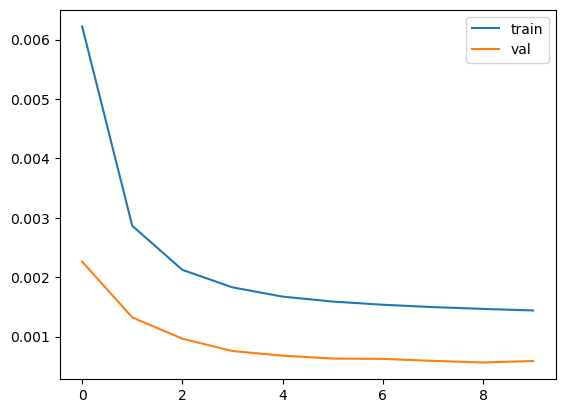

In [285]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [286]:
# Test the model
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
n_test_batches = 100
with torch.no_grad():
    incorrect = 0
    for batch in test_loader:
        n_test_batches -= 1
        if n_test_batches < 0:
            break
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        selfies = [test.devectorize(x) for x in batch]
        selfies = [sf.decoder(x) for x in selfies]
        pred_smiles = [test.devectorize(x) for x in outputs]
        pred_smiles = [sf.decoder(x) for x in pred_smiles]
        for i in range(len(selfies)):
            if selfies[i] != pred_smiles[i]:
                incorrect += 1
                print(f'Actual:    {selfies[i]}')
                # print difference in red color
                print('Predicted: ', end='')
                for j in range(len(selfies[i])):
                    try:
                        if selfies[i][j] != pred_smiles[i][j]:
                            print('\033[91m', end='')
                        print(pred_smiles[i][j], end='')
                        if selfies[i][j] != pred_smiles[i][j]:
                            print('\033[0m', end='')
                    except:
                        pass
                print('\n--------')

Actual:    CCCC12CC(O)CC3C(C)N=C(C31)N(C)C2
Predicted: CCC1C2CC(O)CC3C(C)=C=C(C32)N(C)C
--------
Actual:    CCN(C)C(=NC)C1=CC2=NC(=O)SC2=CS1
Predicted: CC1N(C)C(=NC)C=CC2=NC(=O)SC2=CS1
--------
Actual:    CCC#CC(O)(C#N)C1=C(C)CC(C)OC1
Predicted: CCC[NH1]C(O)(C#N)C1=C(C)CC(C)
--------
Actual:    C#CCC1=C[NH1]C(=O)N1C2=CC(=N)C(Cl)=NS2
Predicted: C#CCC1=C[NH1]C(=O)N1C2=CC(=N)C([N+1])=
--------
Actual:    CC1CCC(C)C2(O)C3=C(C=NN3C=O)CC12
Predicted: C1CCCC(C)C(O)C2=C1C=NN2CC
--------
Actual:    CC=1N=C(C=O)SC2=C(C(C)=C(N)N=1)COC2
Predicted: CCN=C(C=O)SC=C(C(C)=C(N)N=CN)COC
--------
Actual:    CC(CN)CCC1=CC(N)=C(NC(C)C)N1C
Predicted: CC(CNCC)C1=CC(N)=C(NC(C)C)N1C
--------
Actual:    CCC1(NCC(C)OCCO)CCCCOC1
Predicted: CCC(NCC(C)OCCOCCCCO)=C
--------
Actual:    CC1=CSC(=N)C(=N)C=C(O)SC(CCO)=N1
Predicted: CC1=CSC(=N)C(=N)C=C(O)SCCCON1
--------
Actual:    CCC1C2C(CN)OC1(C(C)(C)N)C(C)C2C
Predicted: CC1C2CC(NOC1(C(C)(C)N)CC)C2C
--------
Actual:    CC1=CC(C)=C(I)C(CN=C2[NH1]N=C(N)O2)=N1
Predicted: 

In [287]:
print(f'Accuracy: {100*(1-incorrect/len(test_dataset)):.2f}%', end='')

Accuracy: 99.07%

In [288]:
# Test the model
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    incorrect = 0
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        selfies = [test.devectorize(x) for x in batch]
        selfies = [sf.decoder(x) for x in selfies]
        pred_smiles = [test.devectorize(x) for x in outputs]
        pred_smiles = [sf.decoder(x) for x in pred_smiles]
        for i in range(len(selfies)):
            if selfies[i] != pred_smiles[i]:
                incorrect += 1

In [289]:
print(f'Accuracy: {100*(1-incorrect/len(test_dataset)):.2f}%', end='')

Accuracy: 70.75%

In [142]:
from torchviz import make_dot

In [194]:
x = torch.rand(1,55,31).to(device)
o = model(x)

In [197]:
make_dot(o, params=dict(model.named_parameters()))
#save png
from graphviz import Source
Source(make_dot(o, params=dict(model.named_parameters())).source).render('model.png', view=True)

'model.png.pdf'

In [290]:
def get_models(autoencoder, input_size, hidden_size, num_layers, latent_size):
    '''
    Returns the encoder and decoder with the same weights as the autoencoder
    '''
    encoder = Encoder(input_size, hidden_size, num_layers, latent_size)
    decoder = Decoder(hidden_size, input_size, num_layers, latent_size)
    encoder.load_state_dict(autoencoder.encoder.state_dict())
    decoder.load_state_dict(autoencoder.decoder.state_dict())
    return encoder, decoder

In [291]:
encoder, decoder = get_models(model, input_size, hidden_size, num_layers, latent_size=128)

In [292]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)


In [293]:
# Test the model
encoder.eval()
decoder.eval()
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [324]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
mdma = 'OC(COC1=C2C=CC=CC2=CC=C1)CNC(C)C'
aspirin = 'CC(=O)Oc1ccccc1C(=O)O'
mdma = sf.encoder(mdma)
x = test.vectorize(mdma)
x.shape

(42, 31)

In [325]:
mdma_encoded = encoder(torch.Tensor(x).unsqueeze(0))
print(f'Encoded shape: {mdma_encoded.shape}')
print(f'Encoded: {mdma_encoded}')

Encoded shape: torch.Size([1, 128])
Encoded: tensor([[-0.1328,  0.2659,  0.0683,  0.3370,  0.2319,  0.0577,  0.4329,  0.1266,
          0.0635, -0.3377, -0.1219,  0.1408, -0.3841, -0.1555, -0.3177,  0.1936,
         -0.3633, -0.1549,  1.2481,  0.3215,  0.0596,  0.9259,  0.8194, -0.0911,
          0.5060, -0.1022, -0.0194,  0.5863, -0.7204, -0.3851,  0.9657, -0.0758,
          0.1924,  0.2327,  0.0060, -0.0949, -0.0620, -0.0947, -0.5916,  0.0057,
          0.3766, -0.9046,  0.2369,  0.3277,  0.6909, -0.2099, -0.3416,  0.5544,
         -0.4465, -0.0171,  0.2361, -0.2200,  0.2061,  0.4370,  0.3281,  0.0374,
         -0.1146, -0.5227, -0.2683, -0.1504,  0.5254, -0.8166, -0.0897, -0.0421,
          0.0130, -0.2506, -0.4269,  0.2637, -0.2178, -1.0905,  0.1161, -0.4422,
          0.1663,  0.0703,  0.3906, -0.0593,  0.4430, -0.0415,  0.3800,  0.1501,
         -0.0315, -0.0926, -0.1851,  0.2292, -0.2472,  0.0776,  0.3755,  0.4888,
          0.2505, -0.1545,  0.5452,  0.1185,  0.5294,  0.0631, -

In [326]:
mdma_reconstructed = decoder(mdma_encoded)
mdma_reconstructed = mdma_reconstructed.detach().numpy()
mdma_reconstructed = test.devectorize(mdma_reconstructed[0])

In [327]:
def pretty_str_compare(str, str_pred, color=True):
    if len(str_pred) > len(str):
        str += '-' * (len(str_pred) - len(str))
    elif len(str_pred) < len(str):
        str_pred += '-' * (len(str) - len(str_pred))
    print(f'Actual:    {str}')
    # print difference in red color
    print('Predicted: ', end='')
    for act, pred in zip(str, str_pred):
        if act != pred:
            if color:
                print('\033[91m', end='')
            print(pred, end='')
            if color:
                print('\033[0m', end='')
        else:
            print(pred, end='')

In [328]:
pretty_str_compare('aa', 'aaaaaa')

Actual:    aa----
Predicted: aaaaaa

In [378]:
# accuracy on training set
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    incorrect = 0
    for batch in train_loader:
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.cpu().numpy()
        batch = batch.cpu().numpy()
        selfies = [test.devectorize(x) for x in batch]
        selfies = [sf.decoder(x) for x in selfies]
        pred_smiles = [test.devectorize(x) for x in outputs]
        pred_smiles = [sf.decoder(x) for x in pred_smiles]
        for i in range(len(selfies)):
            if selfies[i] != pred_smiles[i]:
                incorrect += 1

In [382]:
print(f'Accuracy: {incorrect/len(train_dataset):.2f}', end='')

Accuracy: 0.29

In [329]:
pretty_str_compare(mdma, mdma_reconstructed)

Actual:    [O][C][Branch1][P][C][O][C][=C][C][=C][C][=C][C][Ring1][=Branch1][=C][C][=C][Ring1][#Branch2][C][N][C][Branch1][C][C][C]------
Predicted: [C][C][Branch1][Branch2][C][O][C][=C][C][=C][C][=C][C][Ring1][=Branch1][=C][C][=C][Ring1][#Branch2][C][N][C][Branch1][C][C][C]

In [330]:
mdma_smiles = sf.decoder(mdma)
mdma_reconstructed_smiles = sf.decoder(mdma_reconstructed)
pretty_str_compare(mdma_smiles, mdma_reconstructed_smiles)

Actual:    OC(COC1=C2C=CC=CC2=CC=C1)CNC(C)C
Predicted: CC(COC1=C2C=CC)=CC2=CC=C1CNC(C)C

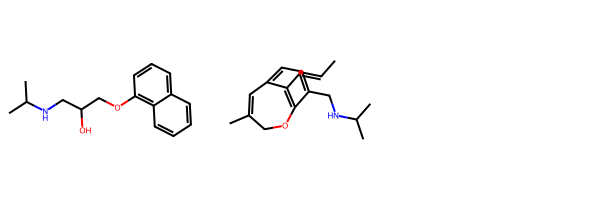

In [331]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(mdma_smiles), Chem.MolFromSmiles(mdma_reconstructed_smiles)])

In [332]:
tanimoto_similarity(mdma_smiles, mdma_reconstructed_smiles)

0.16923076923076924

In [338]:
# calculate distance between two vectors
from scipy.spatial.distance import cosine

In [335]:
mdma_analog = 'CNC(CC1=CC=C2OC(C)OC2=C1)C(C)C'
mdma_analog_vec = test.vectorize(sf.encoder(mdma_analog))
mdma_analog_encoded = encoder(torch.Tensor(mdma_analog_vec).unsqueeze(0))
mdma_analog_decoded = decoder(mdma_analog_encoded)

In [336]:
tanimoto_similarity(mdma_smiles, mdma_analog)

0.13333333333333333

In [340]:
1- cosine(mdma_encoded.detach().numpy()[0], mdma_analog_encoded.detach().numpy()[0])

0.2348005622625351

In [163]:
tanimoto_similarity(mdma_analog, mdma)

0.4318181818181818

In [164]:
cosine(mdma_analog_encoded.detach().numpy()[0], encoded.detach().numpy()[0])

0.7898859232664108

In [341]:
import pubchempy as pcp

In [342]:
# get all amino acids
names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine', 'Glutamic acid', 'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
aa_smiles = []
for name in names:
    aa = pcp.get_compounds(name, 'name')
    print(name, aa[0].canonical_smiles)
    aa_smiles.append(aa[0].canonical_smiles)

Alanine CC(C(=O)O)N
Arginine C(CC(C(=O)O)N)CN=C(N)N
Asparagine C(C(C(=O)O)N)C(=O)N
Aspartic acid C(C(C(=O)O)N)C(=O)O
Cysteine C(C(C(=O)O)N)S
Glutamic acid C(CC(=O)O)C(C(=O)O)N
Glutamine C(CC(=O)N)C(C(=O)O)N
Glycine C(C(=O)O)N
Histidine C1=C(NC=N1)CC(C(=O)O)N
Isoleucine CCC(C)C(C(=O)O)N
Leucine CC(C)CC(C(=O)O)N
Lysine C(CCN)CC(C(=O)O)N
Methionine CSCCC(C(=O)O)N
Phenylalanine C1=CC=C(C=C1)CC(C(=O)O)N
Proline C1CC(NC1)C(=O)O
Serine C(C(C(=O)O)N)O
Threonine CC(C(C(=O)O)N)O
Tryptophan C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N
Tyrosine C1=CC(=CC=C1CC(C(=O)O)N)O
Valine CC(C)C(C(=O)O)N


In [343]:
len(aa_smiles)

20

In [357]:
aa_vec = [test.vectorize(sf.encoder(smi)) for smi in aa_smiles]
aa_encoded = encoder(torch.Tensor(aa_vec))
aa_decoded = decoder(aa_encoded)

In [358]:
aa_encoded = aa_encoded.detach().numpy()
aa_decoded = aa_decoded.detach().numpy()

In [359]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vec_pca = pca.fit_transform(aa_encoded)

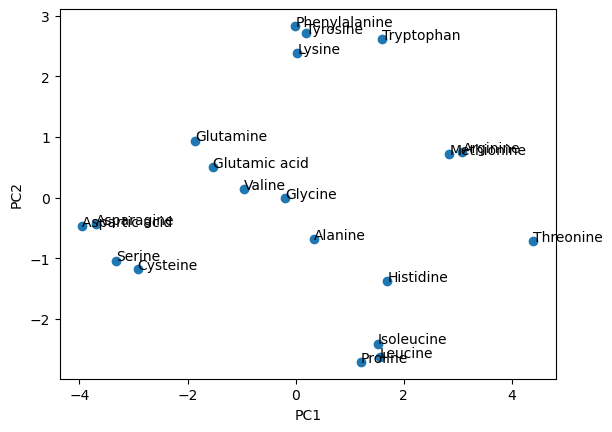

In [360]:
# plot PCA
import matplotlib.pyplot as plt
plt.scatter(vec_pca[:,0], vec_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_pca[i,0], vec_pca[i,1]))

In [362]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=15)
aa_encoded.shape

(20, 128)

In [363]:
vec_tsne = tsne.fit_transform(aa_encoded)

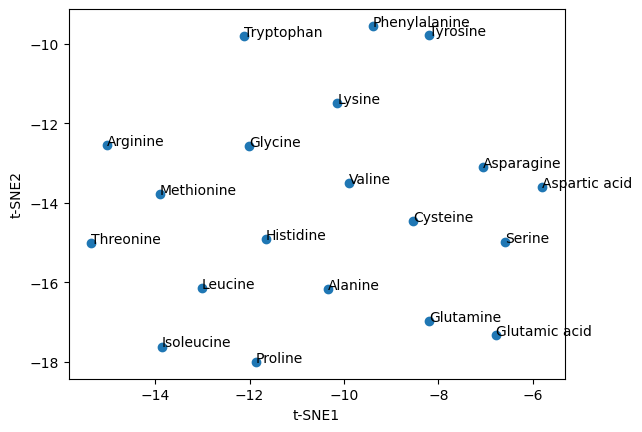

In [364]:
# plot t-SNE
import matplotlib.pyplot as plt
plt.scatter(vec_tsne[:,0], vec_tsne[:,1])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_tsne[i,0], vec_tsne[i,1]))

In [367]:
aa_decoded.shape

(20, 42, 31)

In [368]:
aa_decoded = [test.devectorize(vec) for vec in aa_decoded]
aa_decoded_smiles = [sf.decoder(vec) for vec in aa_decoded]

In [369]:
aa_decoded_smiles

['CC(C(=O)O)NC=NC=NN=C',
 'CCCCC(C(=O)O)NC=NC(N)N',
 'CCCC(C(=O)O)NC(=O)N',
 'CCCC(C(=O)O)NC(=O)O',
 'CCCC(C(=O)O)NS(Br)=N',
 'CCCCC(=O)OC(C(=O)O)N',
 'CCCCC(=O)NC(C(=O)O)N',
 'CCCC(=O)ON(Br)CNN=NN',
 'C1C(NCN1CCC(=O)O)N',
 'CCC(C)C(C(=O)O)N',
 'CC(C)CC(C(=O)O)N',
 'CCCCCNCC(C(=O)O)N',
 'C=CCCC(C(=O)O)N(Br)N=N',
 'C1=CC=C(C=C1)CC(C(=O)O)N',
 'C12CC(NC1C=O)S2=NN',
 'CCCC(C(=O)O)N=S=NC',
 'C1C(C(C(=O)O)N)C1=NC',
 'C1C=2C=C3C=2C1C(CN3)CC(C(=O)O)N',
 'CCC1=NN=CC=C1CC(C(=O)O)=NO',
 'CC(C)C(C(=O)O)NBr']

In [370]:
aa_decoded_mols = [Chem.MolFromSmiles(smi) for smi in aa_decoded_smiles]
aa_mols = [Chem.MolFromSmiles(smi) for smi in aa_smiles]

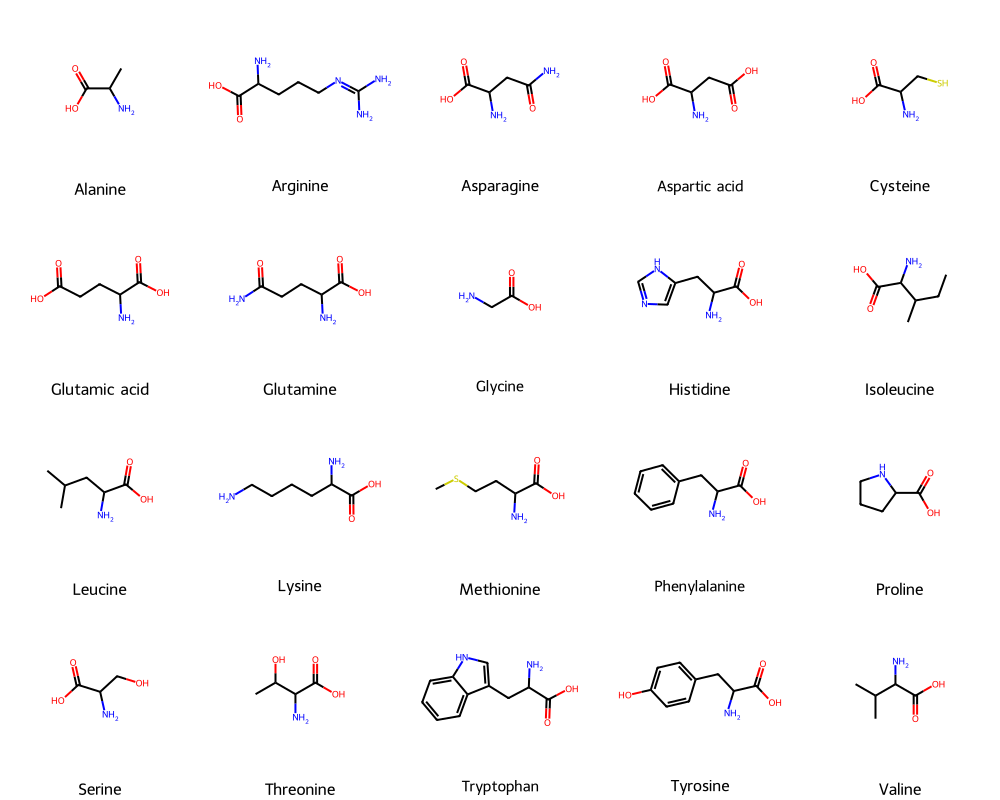

In [372]:
Draw.MolsToGridImage(aa_mols, molsPerRow=5, subImgSize=(200,200), legends=names)

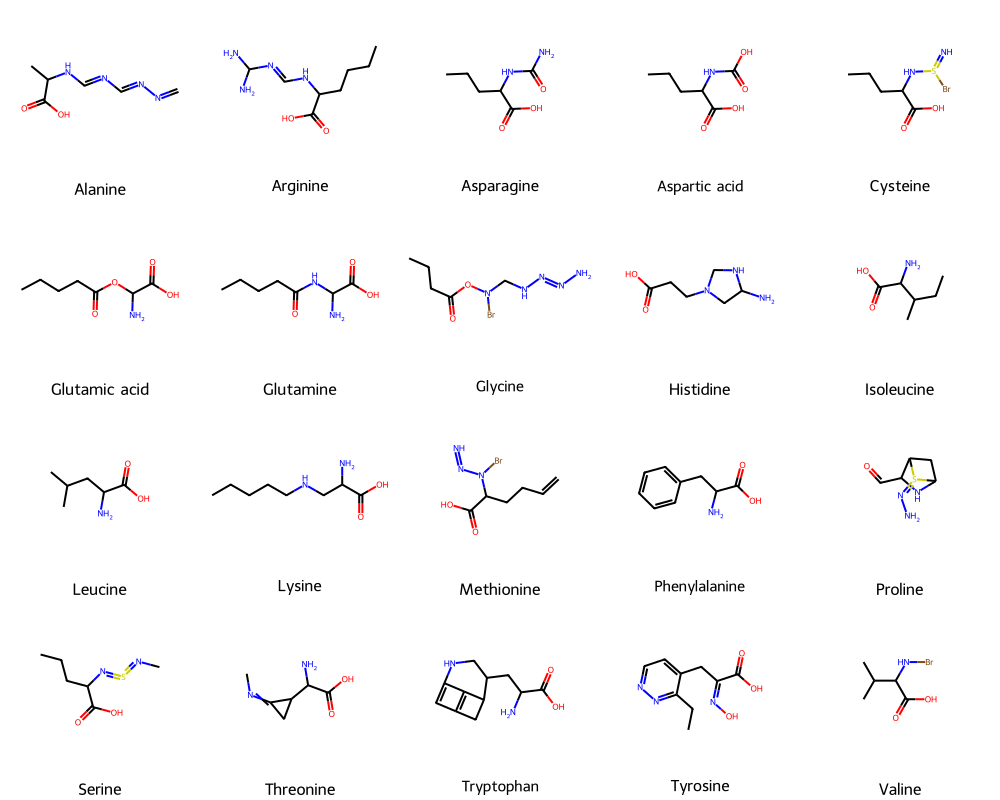

In [373]:
Draw.MolsToGridImage(aa_decoded_mols, molsPerRow=5, subImgSize=(200,200), legends=names)

In [376]:
for real, pred, name in zip(aa_smiles, aa_decoded_smiles, names):
    print(name)
    pretty_str_compare(real, pred)
    print('\n')

Alanine
Actual:    CC(C(=O)O)N---------
Predicted: CC(C(=O)O)NC=NC=NN=C

Arginine
Actual:    C(CC(C(=O)O)N)CN=C(N)N
Predicted: CCCCC(C(=O)O)NC=NC(N)N

Asparagine
Actual:    C(C(C(=O)O)N)C(=O)N
Predicted: CCCC(C(=O)O)NC(=O)N

Aspartic acid
Actual:    C(C(C(=O)O)N)C(=O)O
Predicted: CCCC(C(=O)O)NC(=O)O

Cysteine
Actual:    C(C(C(=O)O)N)S------
Predicted: CCCC(C(=O)O)NS(Br)=N

Glutamic acid
Actual:    C(CC(=O)O)C(C(=O)O)N
Predicted: CCCCC(=O)OC(C(=O)O)N

Glutamine
Actual:    C(CC(=O)N)C(C(=O)O)N
Predicted: CCCCC(=O)NC(C(=O)O)N

Glycine
Actual:    C(C(=O)O)N----------
Predicted: CCCC(=O)ON(Br)CNN=NN

Histidine
Actual:    C1=C(NC=N1)CC(C(=O)O)N
Predicted: C1C(NCN1CCC(=O)O)N----

Isoleucine
Actual:    CCC(C)C(C(=O)O)N
Predicted: CCC(C)C(C(=O)O)N

Leucine
Actual:    CC(C)CC(C(=O)O)N
Predicted: CC(C)CC(C(=O)O)N

Lysine
Actual:    C(CCN)CC(C(=O)O)N
Predicted: CCCCCNCC(C(=O)O)N

Methionine
Actual:    CSCCC(C(=O)O)N--------
Predicted: C=CCCC(C(=O)O)N(Br)N=N

Phenylalanine
Actual:    C1=CC=C(C=C1)C